In [1]:
# Configure notebook
run_name = "earthy-dew-137"
output_dir = "results"
config_path = "configs/mnist_vae_l1.yaml"
epoch = 21
training_labels = "0 2 3 6 7 8 9"


In [2]:
# Load embeddings
from yacs.config import CfgNode
from efir.checkpointer import Checkpointer
from efir.utils import CodeBlock, setup_logger, load_config, cfg_node_to_dict
import numpy as np
from efir.registry import Registry
from efir.model.vae import VAE

cfg = load_config(config_path)
device = cfg.DEVICE

checkpointer = Checkpointer(output_dir + "/" + run_name)
results_file = checkpointer.get_inference_results_path(epoch)
model = checkpointer.load(
    Registry.build_from_cfg(cfg.MODEL),
    epoch=epoch,
).to(device)

resultz = np.load(results_file, allow_pickle=True)

data_tTrue = np.concatenate(resultz["data_tTrue"], axis=0)
labels_tTrue = np.concatenate(resultz["labels_tTrue"], axis=0)
yhat_tTrue = np.concatenate(resultz["yhat_tTrue"], axis=0)
mu_tTrue = np.concatenate(resultz["mu_tTrue"], axis=0)
log_var_tTrue = np.concatenate(resultz["log_var_tTrue"], axis=0)

data_tFalse = np.concatenate(resultz["data_tFalse"], axis=0)
labels_tFalse = np.concatenate(resultz["labels_tFalse"], axis=0)
yhat_tFalse = np.concatenate(resultz["yhat_tFalse"], axis=0)
mu_tFalse = np.concatenate(resultz["mu_tFalse"], axis=0)
log_var_tFalse = np.concatenate(resultz["log_var_tFalse"], axis=0)

mu = np.concatenate([mu_tTrue, mu_tFalse], axis=0)
log_var = np.concatenate([log_var_tTrue, log_var_tFalse], axis=0)
yhat = np.concatenate([yhat_tTrue, yhat_tFalse], axis=0)
data = np.concatenate([data_tTrue, data_tFalse], axis=0)
labels = np.concatenate([labels_tTrue, labels_tFalse], axis=0)
is_train = np.array(([True] * labels_tTrue.shape[0]) + ([False] * labels_tFalse.shape[0]))


/home/haroun7/anaconda3/envs/efir/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


   log_var_norm    mu_norm  labels  is_train
0     18.466593  10.351848       5      True
1     20.045887   6.451206       0      True
2     22.770269  10.182508       4      True
3     19.947252   7.390350       1      True
4     19.590769   7.848432       9      True


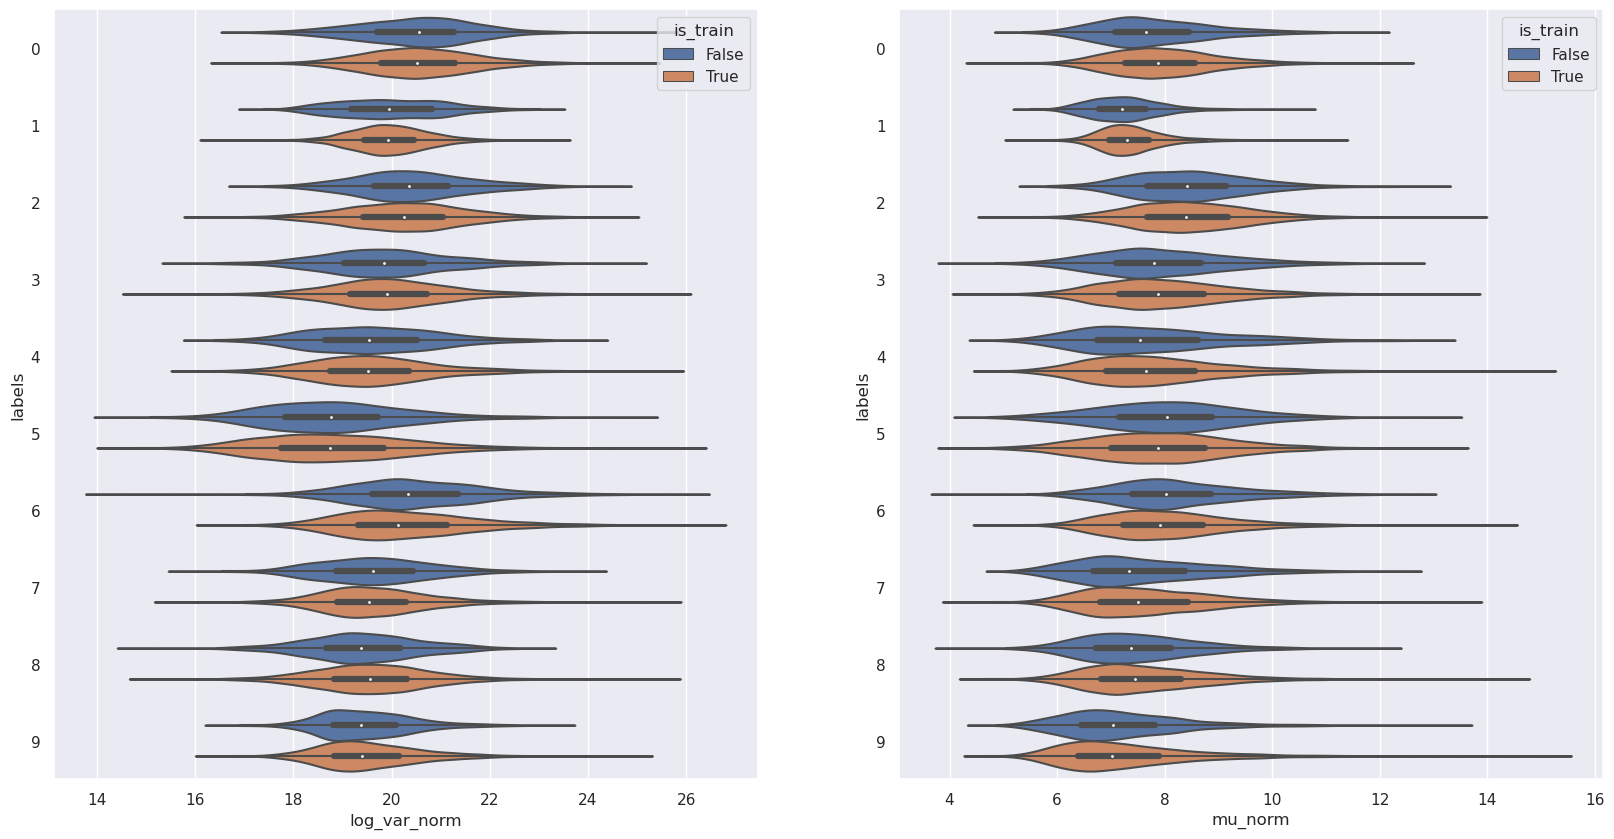

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set()

log_var_norm = np.linalg.norm(log_var, axis=1)

mu_norm = np.linalg.norm(mu, axis=1)

df = pd.DataFrame.from_dict(
    {
        "log_var_norm": log_var_norm,
        "mu_norm": mu_norm,
        "labels": labels,
        "is_train": is_train,
    }
)
print(df.head())
fig, axes = plt.subplots(ncols=2, figsize=(20, 10))
sns.violinplot(df, x="log_var_norm", y="labels", hue="is_train", orient="h", ax=axes[0])#, order=[str(x) for x in range(10)], ax=axes[0])

sns.violinplot(df, x="mu_norm", y="labels", hue="is_train", orient="h", ax=axes[1])#, order=[str(x) for x in range(10)], ax=axes[1])

plt.show()

In [5]:
%%time
# lower dim of embedding
from sklearn.manifold import TSNE

tsne = TSNE()
mu_tsne = tsne.fit_transform(mu)

CPU times: user 19min 51s, sys: 12.8 s, total: 20min 4s
Wall time: 4min 15s


In [12]:
df = pd.DataFrame.from_dict(
    {
        "log_var_norm": log_var_norm,
        "mu_norm": mu_norm,
        "log_var": log_var.tolist(),
        "mu": mu.tolist(),
        "mu_tsne_x": mu_tsne[:, 0],
        "mu_tsne_y": mu_tsne[:, 1],
        "labels": labels,
        "is_train": is_train,
    }
)
df.labels.unique()

array([5, 0, 4, 1, 9, 2, 3, 6, 7, 8])

In [9]:
df.to_pickle("embeddings.pkl")

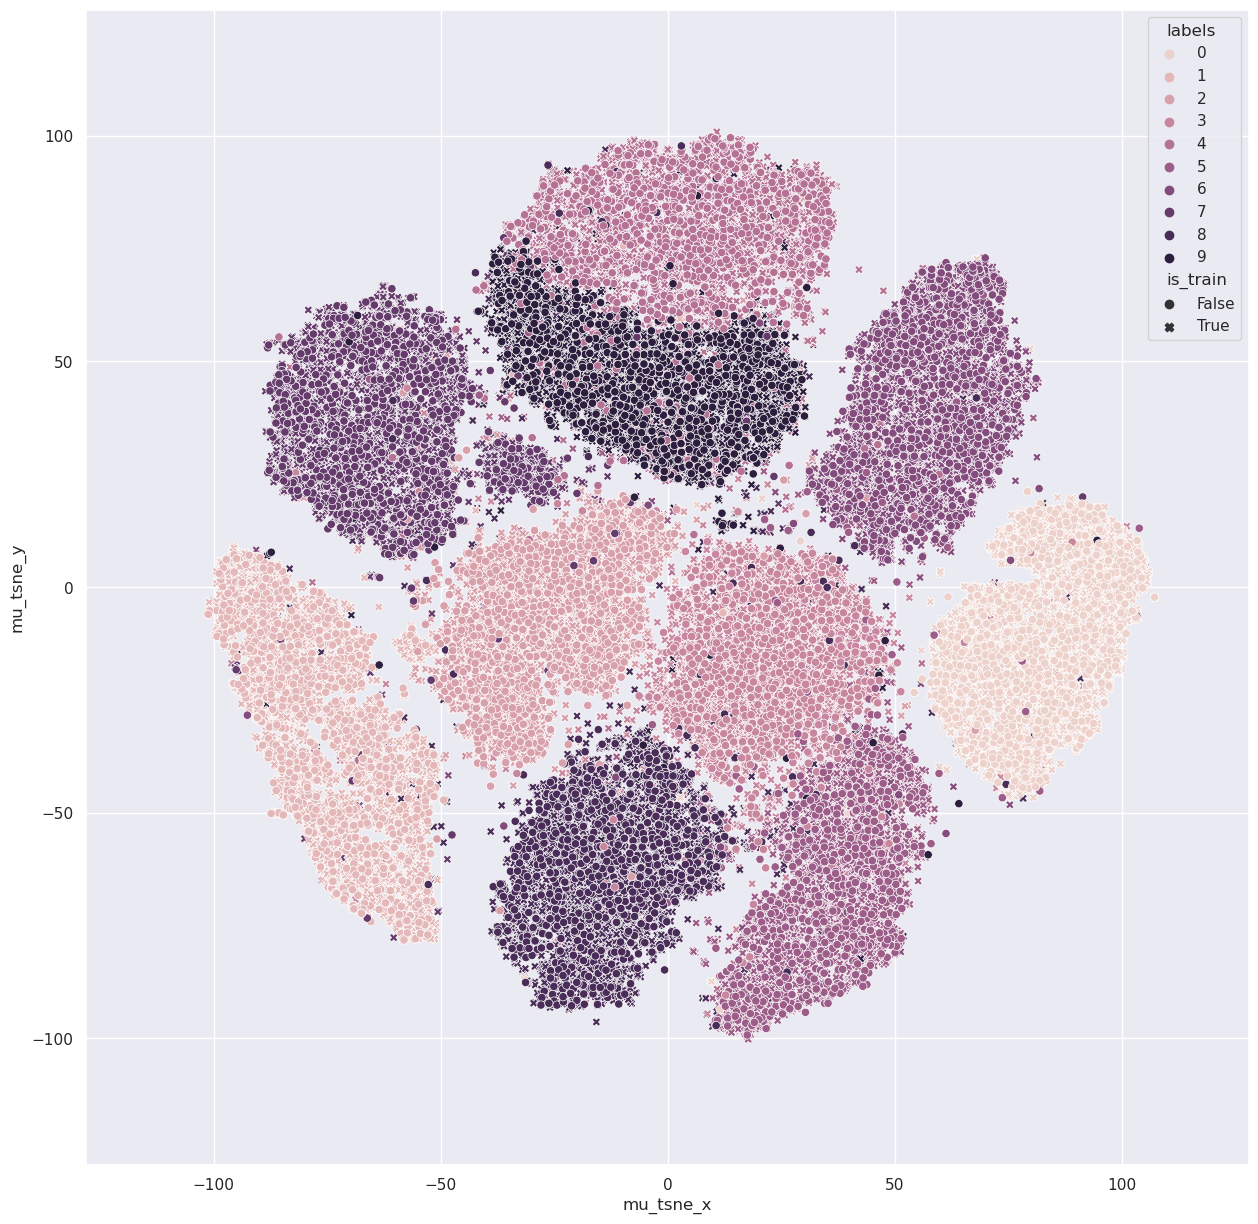

In [7]:
import seaborn as sns
sns.set()

# fig, axes = plt.subplots(ncols=2, figsize=(20, 10))
fig = plt.figure(figsize=(15, 15))
sns.scatterplot(
    df, 
    x="mu_tsne_x", 
    y="mu_tsne_y", 
    hue="labels", 
    # palette=sns.color_palette("husl"), # "Paired",
    style="is_train",
    legend="full",
    hue_order=[str(x) for x in range(10)], 
    # ax=axes[0],
)
plt.xlim(-128, 128)
plt.ylim(-128, 128)
plt.savefig("embeddings.png")
plt.show()

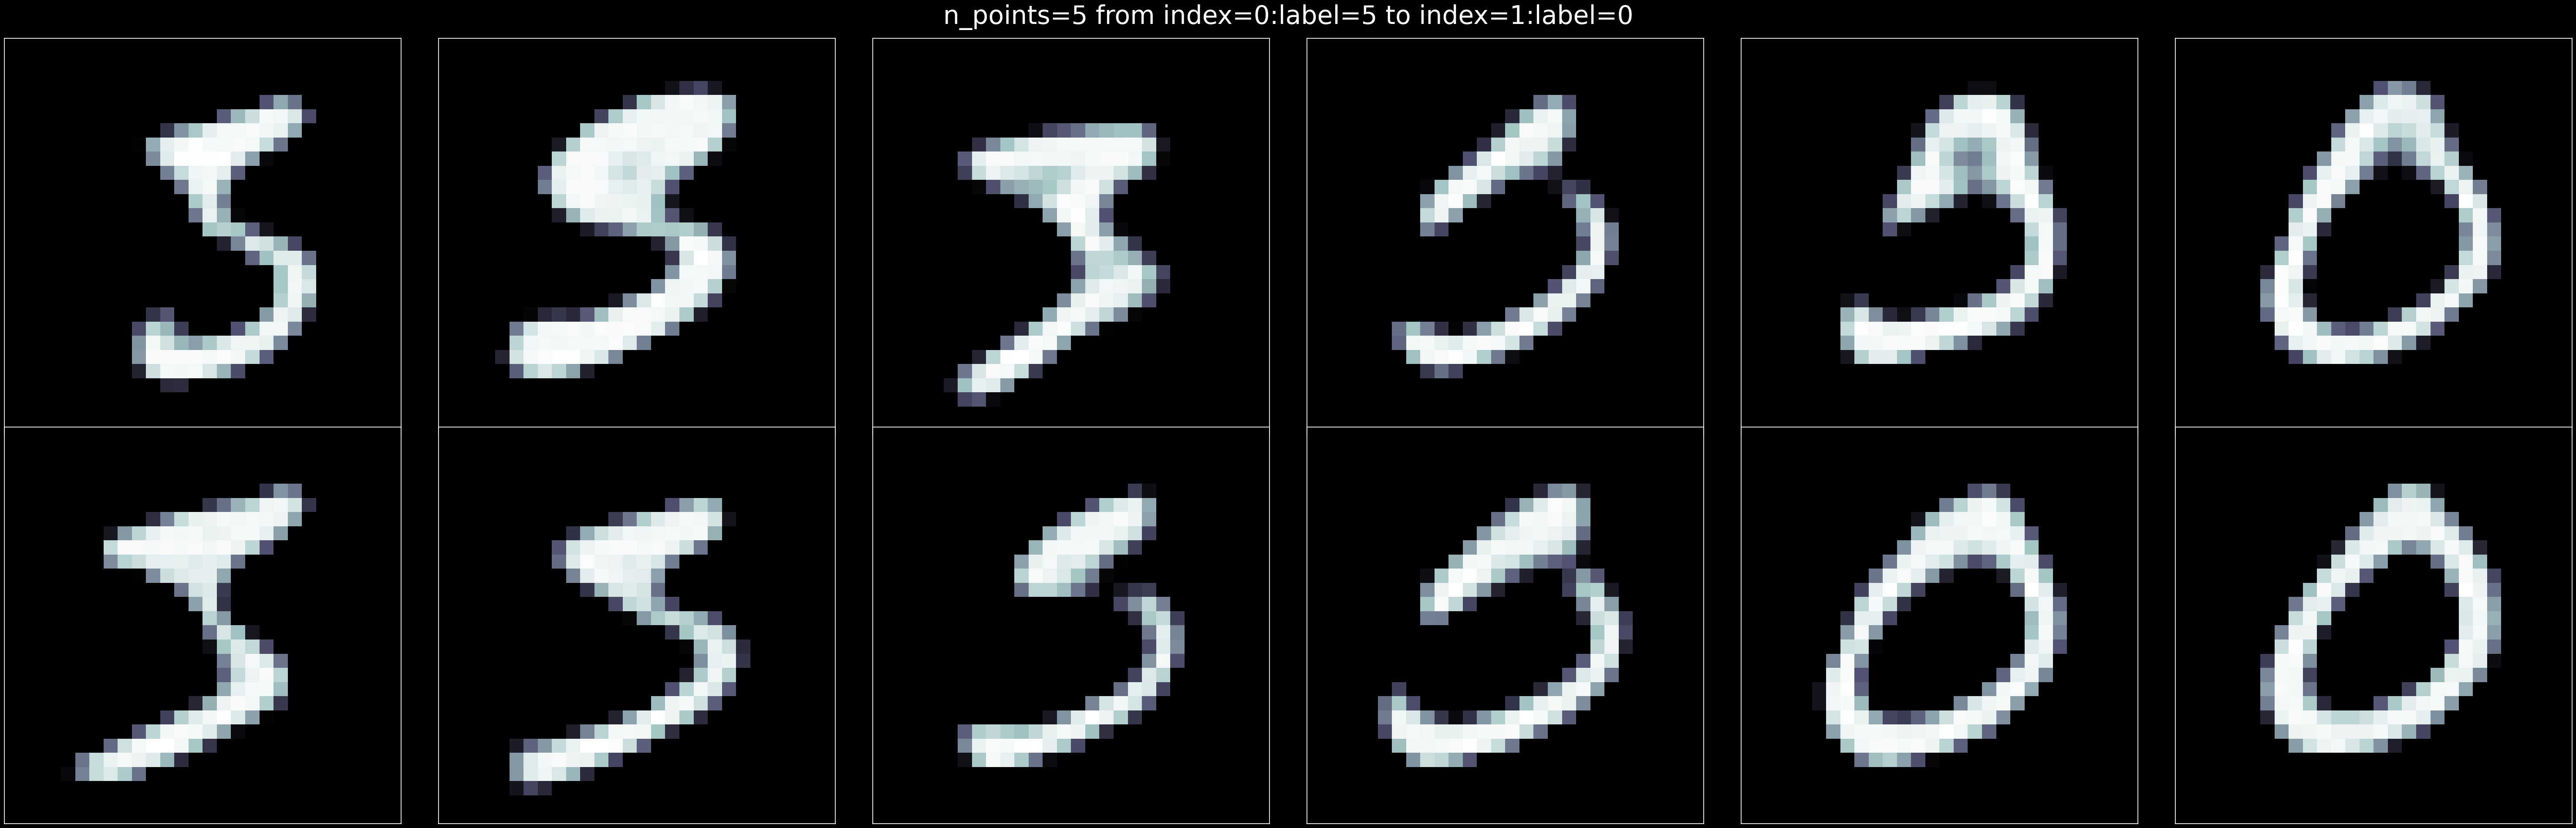

In [89]:
# Interpolating embeddings
import torch


@torch.inference_mode()
def plot_mu_linear_interpolation(left: int, right: int, n_points: int = 5) -> None:
    alpha = np.linspace(0, 1.0, n_points + 1).reshape(-1, 1)
    mu_l = mu[[left], :]
    mu_r = mu[[right], :]
    log_var_l = log_var[[left], :]
    log_var_r = log_var[[right], :]
    mu_t = torch.from_numpy(alpha * mu_r + (1 - alpha) * mu_l).float().to(device)
    log_var_t = torch.from_numpy(alpha * log_var_r + (1 - alpha) * log_var_l).float().to(device)
    yhat_no_noise = model.decode(model.reparameterize(mu_t, log_var_t * 0))
    yhat_noise = model.decode(model.reparameterize(mu_t, log_var_t))
    yhat = torch.stack([yhat_no_noise, yhat_noise], dim=0)
    ncols = 2 + n_points

    fig, axes = plt.subplots(
        nrows=yhat.shape[0], 
        ncols=yhat.shape[1], 
        figsize=(yhat.shape[1] * 10, yhat.shape[0] * 10),
        facecolor="black",
    )
    for row_idx in range(yhat.shape[0]):
        for col_idx in range(yhat.shape[1]):
            axes[row_idx, col_idx].imshow(yhat[row_idx, col_idx, 0].detach().cpu().numpy(), cmap="bone")
            axes[row_idx, col_idx].grid(False)
            axes[row_idx, col_idx].set_xticks([])
            axes[row_idx, col_idx].set_yticks([])
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.suptitle(f"{n_points=} from index={left}:label={labels[left]} to index={right}:label={labels[right]}", color="white", fontsize=42)
    plt.show()

plot_mu_linear_interpolation(0, 1, 5)


In [90]:
# Indices per label
for label in set(labels):
    where_label = (labels == label).nonzero()[0]
    print(f"{label=}: {set(np.random.choice(where_label, size=5, replace=False))}")

label=0: {49280, 29345, 22023, 17048, 61723}
label=1: {36992, 58309, 60967, 47702, 2717}
label=2: {43495, 30794, 58098, 47254, 27641}
label=3: {27783, 47145, 38058, 55566, 11539}
label=4: {14496, 44294, 27222, 69625, 25791}
label=5: {16295, 63113, 31979, 25654, 38940}
label=6: {50242, 18667, 21844, 40244, 29048}
label=7: {42784, 69248, 18472, 15922, 1975}
label=8: {37184, 28962, 25890, 43698, 22099}
label=9: {51521, 24263, 8592, 14164, 58363}


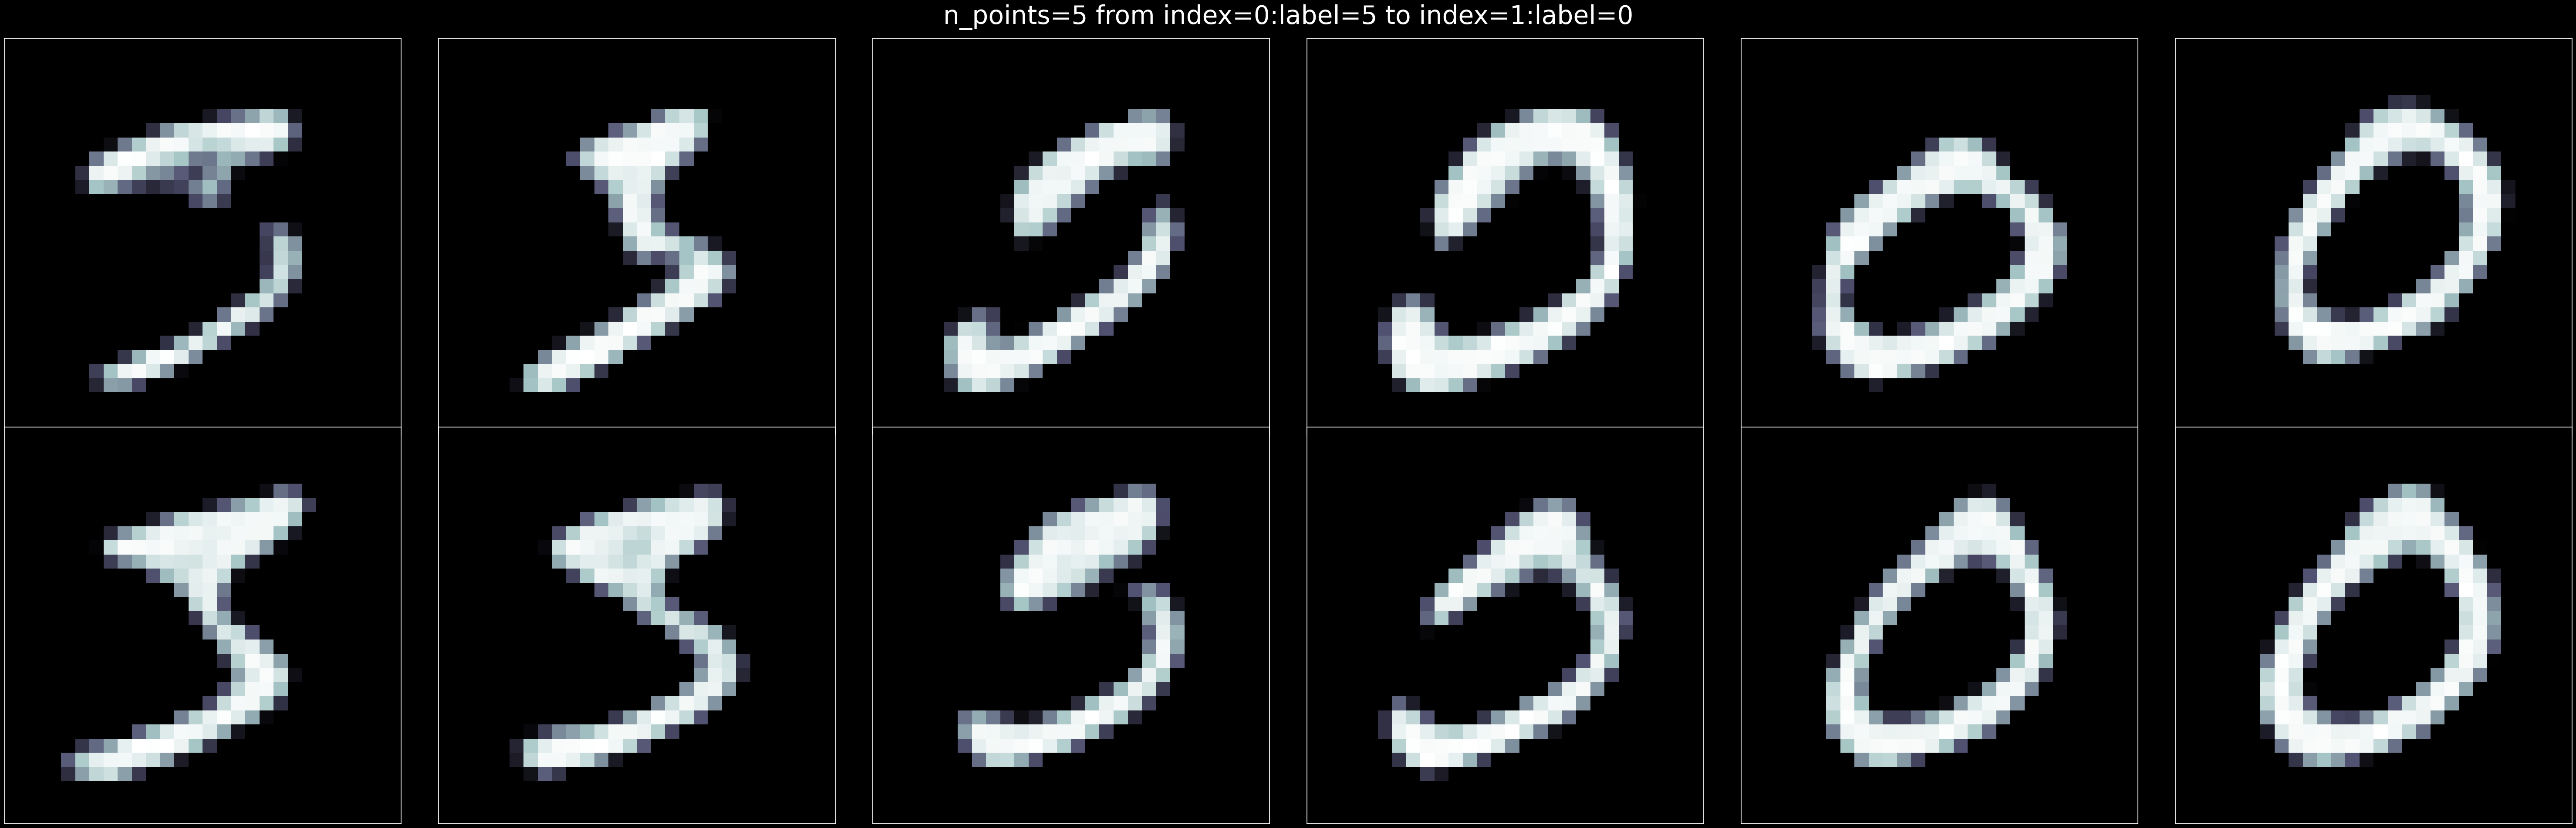

In [91]:
plot_mu_linear_interpolation(0, 1, 5)
